## Importing libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.pipeline import Pipeline as imbPipeline
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt


## Load the data

In [2]:
data = pd.read_csv("../data/fraud_data.csv")
data.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6322570,688,CASH_IN,23557.12,C867750533,8059.00,31616.12,C1026934669,169508.66,145951.53,0,0
3621196,274,PAYMENT,6236.13,C601099070,0.00,0.00,M701283411,0.00,0.00,0,0
1226256,133,PAYMENT,33981.87,C279540931,18745.72,0.00,M577905776,0.00,0.00,0,0
2803274,225,CASH_OUT,263006.42,C11675531,20072.00,0.00,C529577791,390253.56,653259.98,0,0
3201247,249,CASH_OUT,152013.74,C530649214,20765.00,0.00,C1304175579,252719.19,404732.93,0,0


## Drop isFlaggedFraud, step, nameOrig, nameDest

In [3]:
data.drop(['isFlaggedFraud', 'step', 'nameOrig', 'nameDest'], axis=1, inplace=True)


## Prepare the data

In [4]:
X = data.drop("isFraud", axis=1)
y = data["isFraud"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## Identify categorical and numerical columns


In [5]:
categorical_columns = ["type"]
numerical_columns = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]


## Preprocessing

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_columns),
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

undersampler = RandomUnderSampler(random_state=42)

k = 7
selector = SelectKBest(f_classif, k=k)

classifier = LogisticRegression(random_state=42)

pipeline = imbPipeline(
    [
        ("preprocessor", preprocessor),
        ("undersampler", undersampler),
        ("selector", selector),
        ("classifier", classifier),
    ])


# The code below is necessary to get the one-hot encoded feature names after the preprocessing
preprocessor.fit(X)
cat_feature_names = preprocessor.named_transformers_[
    'cat'].get_feature_names_out(categorical_columns)
transformed_feature_names = numerical_columns + cat_feature_names.tolist()


## Search for best parameters

In [7]:
param_dist = {
    "classifier__penalty": ["l1", "l2", "none"],
    "classifier__solver": ["newton-cg", "lbfgs", "saga"],
    "classifier__C": np.logspace(-4, 4, 20),
    "classifier__fit_intercept": [True, False],
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    random_state=42,
)


## Train the model

In [8]:
random_search.fit(X_train, y_train)


c:\Users\kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
70 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\kevin\AppData\Local\Programs\Python\Python311\Lib

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['amount',
                                                                                'oldbalanceOrg',
                                                                                'newbalanceOrig',
                                                                                'oldbalanceDest',
                                                                                'newbalanceDest']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['type'])])),
                                             ('undersampler',
                                              RandomUnderSampler(random_state=42)),
                                             ('selector', SelectKBest(k=7)),
                                             ('class...
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'classifier__fit_intercept': [True,
                                                                      False],
                                        'classifier__penalty': ['l1', 'l2',
                                                                'none'],
                                        'classifier__solver': ['newton-cg',
                                                               'lbfgs',
                                                               'saga']},
                   random_state=42, scoring='f1')

### Extract the best hyperparameters and features

In [9]:
print("Best parameters found:", random_search.best_params_)

selected_features = random_search.best_estimator_['selector'].get_support(indices=True)
selected_feature_names = [transformed_feature_names[i] for i in selected_features]
selected_feature_names


Best parameters found: {'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__fit_intercept': True, 'classifier__C': 0.0018329807108324356}


['amount',
 'newbalanceOrig',
 'oldbalanceDest',
 'type_CASH_IN',
 'type_CASH_OUT',
 'type_PAYMENT',
 'type_TRANSFER']

## Evaluate the model

Accuracy: 0.961618
Precision: 0.015215686274509805
Recall: 0.44907407407407407
F1 Score: 0.02943407677135488
ROC AUC: 0.7056785964980985
| 7 | 0.9616 | 0.0152 | 0.4491 | 0.0294 | 0.7057 | amount, oldbalanceOrg, newbalanceOrig, type_CASH_IN, type_CASH_OUT, type_PAYMENT, type_TRANSFER |
| 0.9616 | 0.0152 | 0.4491 | 0.0294 | 0.7057 |


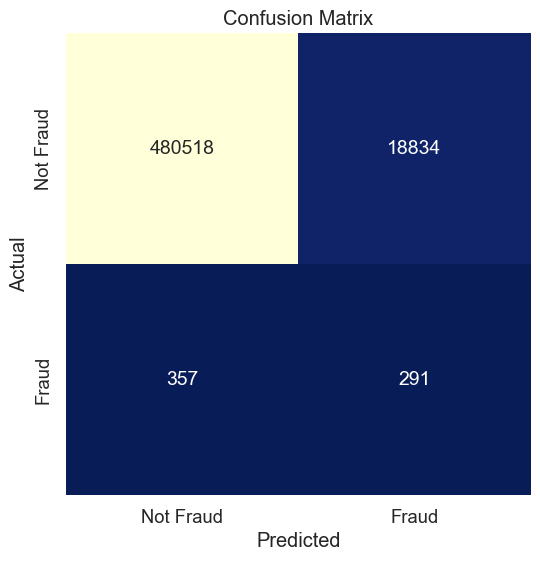

In [ ]:
y_pred = pipeline.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

plt.figure(figsize=(6, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='.0f', cmap='YlGnBu_r', cbar=False, annot_kws={"size": 14},
            xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
